In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
# Add the project root (toy-wm directory) to sys.path so we can import src as a package
# This allows relative imports within the package to work correctly
# Assumes notebook is run from the project root directory
project_root = os.getcwd()  # or use: os.path.dirname(os.path.abspath(''))
print(project_root)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

/share/u/wendler/code/toy-wm


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch as t

# Import using absolute path from src package
from src.utils.checkpoint import load_model_from_config

#model = load_model_from_config("configs/small_6frame.yaml")
model = load_model_from_config("configs/inference.yaml", strict=False)
model.eval()

In [ ]:
model.activate_caching2(1)

In [ ]:
from src.datasets.pong1m import get_loader

loader, pred2frame = get_loader(duration=1, fps=30, mode='-1,1')
frames, actions = next(iter(loader))
frames = pred2frame(frames)

520 batches


In [ ]:
from src.trainers.diffusion_forcing import sample

def render_video(actions, n_steps=4, cfg=0, negative_actions=None, clamp=True):
    model.cache.reset()
    device = model.device
    frames = t.randn(1, actions.shape[1], 3, 24, 24, device="cpu")
    for aidx in range(actions.shape[1]):
        print(aidx)
        noise=t.randn(1, 1, 3, 24, 24, device=model.device)
        z = sample(model, noise, actions[:, aidx:aidx+1], num_steps=n_steps, cfg=cfg, negative_actions=negative_actions)
        model.cache.update_global_location(1)
        frames[:, aidx:aidx+1] = z.detach().cpu()
        if clamp:
            frames = frames.clamp(-1, 1)
    return frames

In [ ]:
#model = t.compile(model)

In [ ]:
#actions = t.tensor([[0]+40*[2]+20*[3]+60*[1]], dtype=t.int32, device=model.device)
actions = t.tensor([[0] + 100*[1]], dtype=t.int32, device=model.device)
negative_actions = t.tensor([[0]+29*[2]], dtype=t.int32, device=model.device)
z = render_video(actions, n_steps=4, cfg=0, negative_actions=None, clamp=False)
frames = pred2frame(z)
# 35.5 with preinit noise
# 5 fps with 30 context
# 281/40.6 = 7fps with 15 context
# 8.5 fps with 5 context
# 9.5 fps with 1 context

0
0 0 0 0
0 1 0 0
0 2 0 0
0 3 0 0
0 4 0 0
0 5 0 0
0 6 0 0
0 7 0 0
1 0 0 0
1 1 0 0
1 2 0 0
1 3 0 0
1 4 0 0
1 5 0 0
1 6 0 0
1 7 0 0
2 0 0 0
2 1 0 0
2 2 0 0
2 3 0 0
2 4 0 0
2 5 0 0
2 6 0 0
2 7 0 0
3 0 0 0
3 1 0 0
3 2 0 0
3 3 0 0
3 4 0 0
3 5 0 0
3 6 0 0
3 7 0 0
1
0 0 65 65
0 1 65 65
0 2 65 65
0 3 65 65
0 4 65 65
0 5 65 65
0 6 65 65
0 7 65 65
1 0 65 65
1 1 65 65
1 2 65 65
1 3 65 65
1 4 65 65
1 5 65 65
1 6 65 65
1 7 65 65
2 0 65 65
2 1 65 65
2 2 65 65
2 3 65 65
2 4 65 65
2 5 65 65
2 6 65 65
2 7 65 65
3 0 65 65
3 1 65 65
3 2 65 65
3 3 65 65
3 4 65 65
3 5 65 65
3 6 65 65
3 7 65 65
2
0 0 130 130
0 1 130 130
0 2 130 130
0 3 130 130
0 4 130 130
0 5 130 130
0 6 130 130
0 7 130 130
1 0 130 130
1 1 130 130
1 2 130 130
1 3 130 130
1 4 130 130
1 5 130 130
1 6 130 130
1 7 130 130
2 0 130 130
2 1 130 130
2 2 130 130
2 3 130 130
2 4 130 130
2 5 130 130
2 6 130 130
2 7 130 130
3 0 130 130
3 1 130 130
3 2 130 130
3 3 130 130
3 4 130 130
3 5 130 130
3 6 130 130
3 7 130 130
3
0 0 195 195
0 1 195 195
0 2 195 

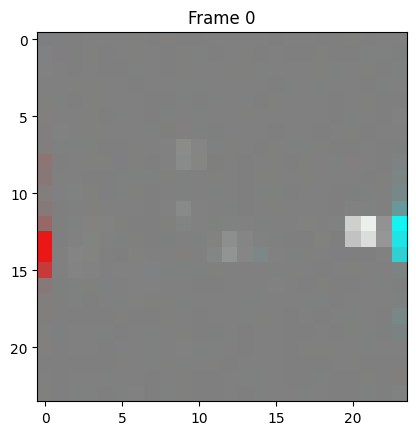

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# z[0] shape: (num_frames, height, width, 3), where num_frames = frames.shape[1]
frames_np = frames[0].permute(0, 2, 3, 1).cpu().numpy()  # shape: (num_frames, height, width, 3)

fig, ax = plt.subplots()
im = ax.imshow(frames_np[0])
ax.set_title('Frame 0')

def animate(i):
    im.set_data(frames_np[i])
    ax.set_title(f'Frame {i}')
    return [im]

ani = animation.FuncAnimation(
    fig, animate, frames=frames_np.shape[0],
    interval=200, blit=True, repeat=True
)

plt.show()

# Optional: To save the gif uncomment below (requires pillow, install with `pip install pillow`)
from collections import Counter
# Majority vote over values in actions for the filename
if actions is not None:
    # Flatten actions tensor and convert to list
    action_vals = actions.flatten().tolist()
    majority_val = Counter(action_vals).most_common(1)[0][0]
    ani.save(f"sample_{majority_val}.gif", writer="pillow")
else:
    ani.save("sample_unknown.gif", writer="pillow")

In [ ]:
print(model.cache)

KVCacheMine()


In [ ]:
model.deactivate_caching() 

In [ ]:
model.bidirectional

False

In [ ]:
x = t.randn(1, 30, 3, 24, 24, device=model.device)
actions = t.tensor([[0]+29*[1]], dtype=t.int32, device=model.device)
ts = t.tensor([[1]], dtype=t.float32, device=model.device)
v = model(x, actions, ts)
pred = x + v



In [ ]:
frame = pred2frame(pred)

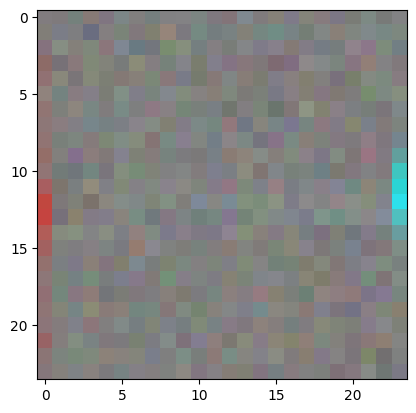

In [ ]:
plt.imshow(frame[0,0].permute(1,2,0).cpu().numpy())
plt.show()